In [1]:
import os as os
import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from matplotlib.ticker import ScalarFormatter
RANDOM_SEED = 4555
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Set parameters and generate data using a linear model¶


In [9]:
# set up the model and data
np.random.seed(RANDOM_SEED)
size = 100
true_intercept = 1
true_slope = 2
sigma = 0.2
x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + np.random.normal(0, sigma ** 2, size)
s = sigma

# reduced datasets
# We use fewer data in the coarse models compared to the fine model in order to make them less accurate
x_coarse_0 = x[::3]
y_coarse_0 = y[::3]
x_coarse_1 = x[::2]
y_coarse_1 = y[::2]

# MCMC parameters
ndraws = 3000
ntune = 1000
nsub = 5
nchains = 2

print(f"x.shape = {x.shape}")
print(f"x_coarse_1.shape = {x_coarse_1.shape}")
print(f"x_coarse_0.shape = {x_coarse_0.shape}")

x.shape = (100,)
x_coarse_1.shape = (50,)
x_coarse_0.shape = (34,)


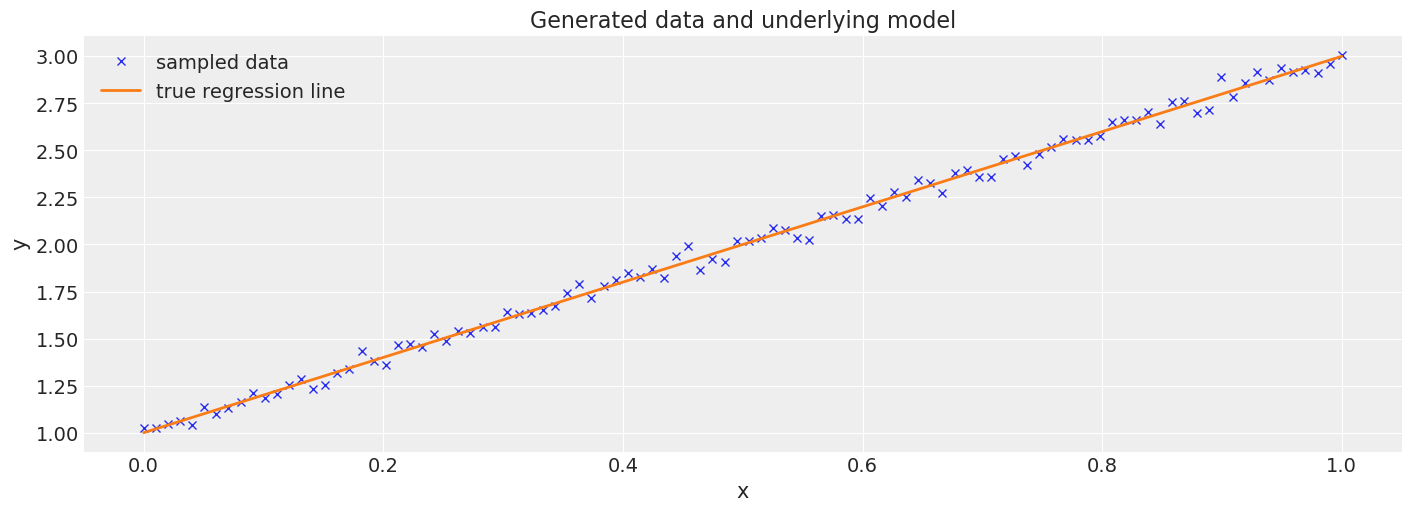

In [16]:
# Plot the data
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### Create a theano op that implements the likelihood

In order to use variance reduction, the user needs to define a Theano Op that calculates the forward model (or both the forward model and the likelihood). Also, this Op needs to save the quantity of interest to a model variable with the name Q. Here we use a Theano Op that contains both the forward model (i.e. the linear equation in this case) and the likelihood calculation. The quantity of interest is calculated with the perform() function and it is the mean of linear predictions given theta from all data points.

In [24]:
class Likelihood(tt.Op):
    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model) and returning a scalar (likelihood)
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, x, y, pymc3_model):
        """
        Initialise the Op with various things that our likelihood requires.
        Parameters
        ----------
        x:
            The x points.
        y:
            The y points.
        pymc3_model:
            The pymc3 model.
        """
        self.x = x
        self.y = y
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        # this uses the linear model to calculate outputs
        temp = intercept + x_coeff * self.x
        # this saves the quantity of interest to the pymc3 model variable Q
        self.pymc3_model.Q.set_value(temp.mean())
        # this calculates the likelihood value
        outputs[0][0] = np.array(-(0.5 / s ** 2) * np.sum((temp - self.y) ** 2))

### Define the coarse models

Here we create the coarse models for MLDA. We need to include a pm.Data() variable Q in each one of those models, instantiated at 0.0. These variables are set during sampling when the Op code under perform() runs.

In [18]:
mout = []
coarse_models = []

# Set up models in pymc3 for each level - excluding finest model level
# Level 0 (coarsest)
with pm.Model() as coarse_model_0:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data("Q", np.float(0.0))

    # Define priors
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])

    # Here we instatiate a Likelihood obhect using the class defined above
    # and we add to the mout list. We pass the coarse data x_coarse_0 and y_coarse_0
    # and the coarse pymc3 model coarse_model_0. This creates a coarse likelihood.
    mout.append(Likelihood(x_coarse_0, y_coarse_0, coarse_model_0))

    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential("likelihood", mout[0](theta))

    coarse_models.append(coarse_model_0)

# Level 1
with pm.Model() as coarse_model_1:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data("Q", np.float64(0.0))

    # Define priors
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])

    # Here we instatiate a Likelihood obhect using the class defined above
    # and we add to the mout list. We pass the coarse data x_coarse_1 and y_coarse_1
    # and the coarse pymc3 model coarse_model_1. This creates a coarse likelihood.
    mout.append(Likelihood(x_coarse_1, y_coarse_1, coarse_model_1))

    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential("likelihood", mout[1](theta))

    coarse_models.append(coarse_model_1)

C:\Users\rasmu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [23]:
coarse_models

[<pymc3.model.Model at 0x2b25eb08f88>, <pymc3.model.Model at 0x2b25eb08308>]

### Define the fine model and sample

Here we define the fine (i.e. correct) model and sample from it using MLDA (with and without variance reduction). Note that Q is used here too.

We create two MLDA samplers, one with VR activated and one without.

In [25]:
with pm.Model() as model:
    # A variable Q has to be defined if you want to use the variance reduction feature
    # Q can be of any dimension - here it a scalar
    Q = pm.Data("Q", np.float64(0.0))

    # Define priors
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([intercept, x_coeff])

    # Here we instatiate a Likelihood object using the class defined above
    # and we add to the mout list. We pass the fine data x and y
    # and the fine pymc3 model model. This creates a fine likelihood.
    mout.append(Likelihood(x, y, model))

    # This uses the likelihood object to define the likelihood of the model, given theta
    pm.Potential("likelihood", mout[-1](theta))

    # MLDA with variance reduction
    step_with = pm.MLDA(
        coarse_models=coarse_models, subsampling_rates=nsub, variance_reduction=True
    )

    # MLDA without variance reduction
    step_without = pm.MLDA(
        coarse_models=coarse_models,
        subsampling_rates=nsub,
        variance_reduction=False,
        store_Q_fine=True,
    )

    # sample
    trace1 = pm.sample(
        draws=ndraws,
        step=step_with,
        chains=nchains,
        tune=ntune,
        discard_tuned_samples=True,
        random_seed=RANDOM_SEED,
        cores=1,
    )

    trace2 = pm.sample(
        draws=ndraws,
        step=step_without,
        chains=nchains,
        tune=ntune,
        discard_tuned_samples=True,
        random_seed=RANDOM_SEED,
        cores=1,
    )

C:\Users\rasmu\Anaconda3\lib\site-packages\pymc3\step_methods\mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
C:\Users\rasmu\Anaconda3\lib\site-packages\pymc3\step_methods\mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
C:\Users\rasmu\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
MLDA: [x, Intercept]


C:\Users\rasmu\Anaconda3\lib\site-packages\pymc3\step_methods\mlda.py:771: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}


C:\Users\rasmu\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.


C:\Users\rasmu\Anaconda3\lib\site-packages\pymc3\step_methods\mlda.py:771: RuntimeWarning: overflow encountered in exp
  stats = {"tune": self.tune, "accept": np.exp(accept), "accepted": accepted}


### Show stats summary

In [26]:
with model:
    trace1_az = az.from_pymc3(trace1)
az.summary(trace1_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.002,0.039,0.933,1.080,0.001,0.001,2501.0,2887.0,1.0
x,1.996,0.067,1.875,2.123,0.001,0.001,2536.0,2862.0,1.0


In [27]:
with model:
    trace2_az = az.from_pymc3(trace2)
az.summary(trace2_az)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.002,0.041,0.924,1.075,0.001,0.001,3186.0,3919.0,1.0
x,1.997,0.070,1.866,2.127,0.001,0.001,3263.0,3773.0,1.0


### Show traceplots

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

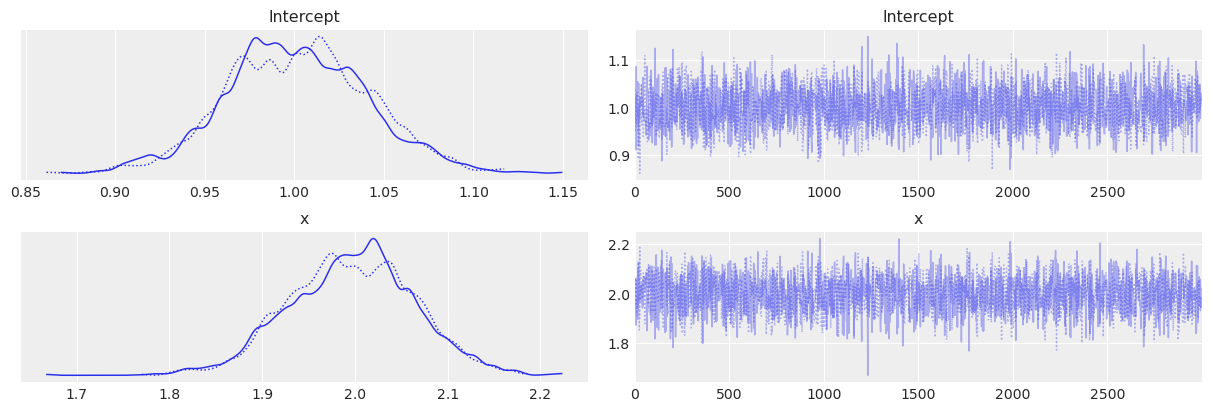

In [28]:
az.plot_trace(trace1_az)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

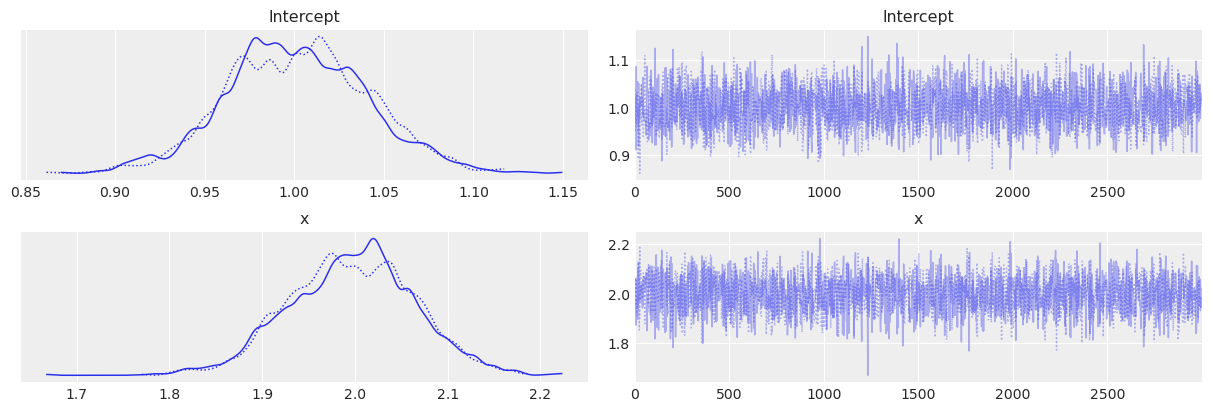

In [29]:
az.plot_trace(trace1_az)

here

In [33]:
# MLDA without VR
Q_2 = trace2.get_sampler_stats("Q_2").reshape((1, nchains * ndraws))

# MLDA with VR
Q_0 = np.concatenate(trace1.get_sampler_stats("Q_0")).reshape((1, nchains * ndraws * nsub * nsub))
Q_1_0 = np.concatenate(trace1.get_sampler_stats("Q_1_0")).reshape((1, nchains * ndraws * nsub))
Q_2_1 = np.concatenate(trace1.get_sampler_stats("Q_2_1")).reshape((1, nchains * ndraws))

print(Q_2.shape)
print(Q_0.shape)
print(Q_1_0.shape)
print(Q_2_1.shape)

(1, 6000)
(1, 150000)
(1, 30000)
(1, 6000)


In [40]:
trace1.stat_names

{'Q_0',
 'Q_1_0',
 'Q_2_1',
 'accept',
 'accepted',
 'base_lambda',
 'base_scaling',
 'tune'}

This shows that the variances of the differences is orders of magnitude smaller than the variance of any of the chains

In [43]:
Q_2.var()

0.000414235279421214

In [44]:
Q_0.var()

0.0010760873150945423

In [45]:
Q_1_0.var()

2.3175382954631006e-07

In [46]:
Q_2_1.var()

1.1469959605972495e-07

### Calculate standard error of each term using ESS

In [47]:
ess_Q0 = az.ess(np.array(Q_0, np.float64))
ess_Q_1_0 = az.ess(np.array(Q_1_0, np.float64))
ess_Q_2_1 = az.ess(np.array(Q_2_1, np.float64))
ess_Q2 = az.ess(np.array(Q_2, np.float64))

# note that the chain in level 2 has much fewer samples than the chain in level 0 (because of the subsampling rates)
print(ess_Q2, ess_Q0, ess_Q_1_0, ess_Q_2_1)

3583.1266973140664 21397.98945004871 8294.638940009752 2533.2315562978047
